
SVM with kernel='linear' (C=1.0, gamma=scale)
Accuracy: 0.956140350877193
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.95      0.94        43
           1       0.97      0.96      0.96        71

    accuracy                           0.96       114
   macro avg       0.95      0.96      0.95       114
weighted avg       0.96      0.96      0.96       114

Cross-validation scores: [0.96703297 0.96703297 0.98901099 0.96703297 0.94505495]
Mean CV Accuracy: 0.9670329670329672


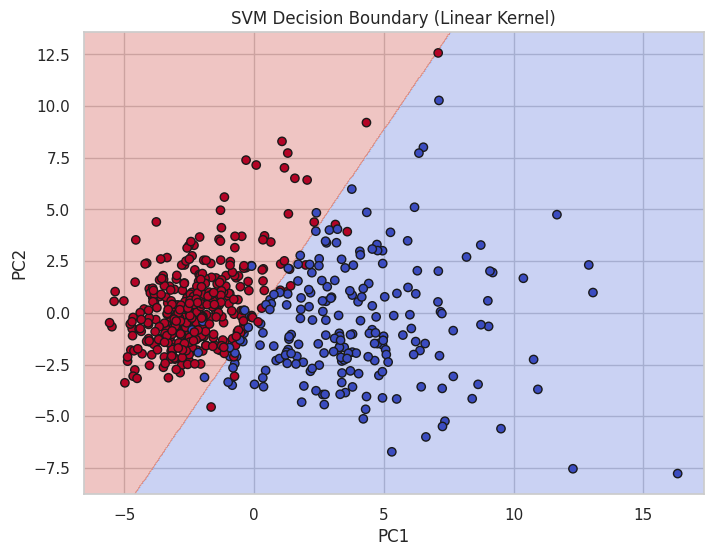


SVM with kernel='rbf' (C=1.0, gamma=scale)
Accuracy: 0.9736842105263158
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.95      0.96        43
           1       0.97      0.99      0.98        71

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114

Cross-validation scores: [0.97802198 0.96703297 0.98901099 0.98901099 0.94505495]
Mean CV Accuracy: 0.9736263736263737


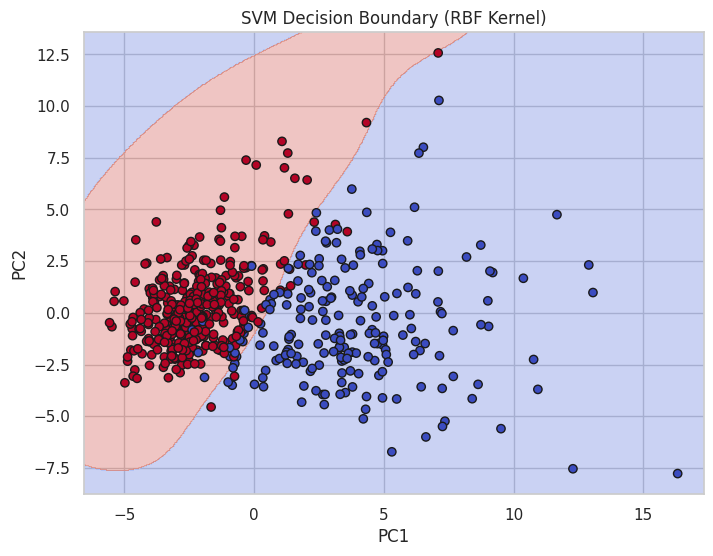


Tuning hyperparameters for RBF kernel:
Best Hyperparameters from GridSearch: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Tuned Model Accuracy: 0.9736842105263158


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (8, 6)

# -------------------- Load and Preprocess Data -------------------- #
def load_and_prepare_data():
    data = load_breast_cancer()
    X = data.data
    y = data.target
    feature_names = data.feature_names
    target_names = data.target_names

    # Normalize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    return train_test_split(X_scaled, y, test_size=0.2, random_state=42), feature_names, target_names

# -------------------- Train and Evaluate SVM -------------------- #
def train_svm(X_train, X_test, y_train, y_test, kernel='linear', C=1.0, gamma='scale'):
    model = SVC(kernel=kernel, C=C, gamma=gamma)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"\nSVM with kernel='{kernel}' (C={C}, gamma={gamma})")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))

    return model

# -------------------- Visualize Decision Boundary (2D PCA) -------------------- #
def visualize_decision_boundary(model, X, y, title):
    pca = PCA(n_components=2)
    X_reduced = pca.fit_transform(X)

    # Retrain on PCA-reduced data
    model.fit(X_reduced, y)

    # Create meshgrid
    x_min, x_max = X_reduced[:, 0].min() - 1, X_reduced[:, 0].max() + 1
    y_min, y_max = X_reduced[:, 1].min() - 1, X_reduced[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                         np.linspace(y_min, y_max, 500))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, cmap='coolwarm', alpha=0.3)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap='coolwarm', edgecolors='k')
    plt.title(title)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.show()

# -------------------- Hyperparameter Tuning -------------------- #
def tune_hyperparameters(X_train, y_train):
    param_grid = {
        'C': [0.1, 1, 10],
        'gamma': ['scale', 0.01, 0.1, 1],
        'kernel': ['rbf']
    }
    grid = GridSearchCV(SVC(), param_grid, cv=5)
    grid.fit(X_train, y_train)
    print("Best Hyperparameters from GridSearch:", grid.best_params_)
    return grid.best_estimator_

# -------------------- Cross-Validation -------------------- #
def cross_validate(model, X, y):
    scores = cross_val_score(model, X, y, cv=5)
    print("Cross-validation scores:", scores)
    print("Mean CV Accuracy:", np.mean(scores))

# -------------------- Main Workflow -------------------- #
def main():
    (X_train, X_test, y_train, y_test), feature_names, target_names = load_and_prepare_data()

    # Linear SVM
    linear_svm = train_svm(X_train, X_test, y_train, y_test, kernel='linear')
    cross_validate(linear_svm, X_train, y_train)
    visualize_decision_boundary(SVC(kernel='linear'), np.vstack((X_train, X_test)), np.hstack((y_train, y_test)),
                                "SVM Decision Boundary (Linear Kernel)")

    # RBF SVM
    rbf_svm = train_svm(X_train, X_test, y_train, y_test, kernel='rbf')
    cross_validate(rbf_svm, X_train, y_train)
    visualize_decision_boundary(SVC(kernel='rbf'), np.vstack((X_train, X_test)), np.hstack((y_train, y_test)),
                                "SVM Decision Boundary (RBF Kernel)")

    # Tuning
    print("\nTuning hyperparameters for RBF kernel:")
    best_model = tune_hyperparameters(X_train, y_train)
    y_pred = best_model.predict(X_test)
    print("Tuned Model Accuracy:", accuracy_score(y_test, y_pred))

if __name__ == "__main__":
    main()
